# Parkinson's Telemonitoring

## Problem description

The unified Parkinson's disease rating scale (UPDRS) is used to follow the progression of a person's Parkinson's disease. 

It is very important to monitor this quantity over time as clinicians and scientifics use it to provide adequate cares regarding the stage of the disease, or to measure benefits from the therapy. 

The goal of this project will be to predict the total UPDRS and motor UPDRS of a patient using a non-invasing method. 

The dataset used here is composed of a range of biomedical voice measurements from 42 people with early-stage Parkinson's disease recruited to a six-month trial of a telemonitoring device for remote symptom progression monitoring. The recordings were automatically captured in the patient's homes. 

The dataset can be found in https://archive.ics.uci.edu/ml/datasets/parkinsons+telemonitoring and is taken from -- <cite>A Tsanas, MA Little, PE McSharry, LO Ramig (2009), 'Accurate telemonitoring of Parkinson’s disease progression by non-invasive speech tests', IEEE Transactions on Biomedical Engineering</cite> --

In [1]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#Load the dataset
df = pd.read_csv('Parkinson/parkinsons_updrs.data')

In [3]:
df.describe()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,...,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,...,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,...,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,...,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,...,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,...,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,...,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,...,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


The dataset is composed of 22 columns:
* **subject#**: Patient id.
* **age**: Patient age.
* **sex**: Patient sex (male 0, female 1)
* **test_time**: Time since recruitment into the trial. The integer part is the number of days since recruitment.
* **Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP**: Several measures of variation in fundamental frequency.
* **Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA**: Several measures of variation in amplitude.
* **NHR,HNR**: Two measures of ratio of noise to tonal components in the voice.
* **RPDE**: A nonlinear dynamical complexity measure.
* **DFA**: Signal fractal scaling exponent.
* **PPE**: A nonlinear measure of fundamental frequency variation.
* **motor_UPDRS**: Clinician's motor Unified Parkinson's Disease Rating Scale (UPDRS) score, linearly interpolated.
* **total_UPDRS**: Clinician's total Unified Parkinson's Disease Rating Scale (UPDRS) score, linearly interpolated.

This problem is therefore a **regression** problem with **multi-target variables** (total_UPDRS and motor_UPDRS).

## Data analysis and preparation

Let's look first plot our data to see if something spots out. 

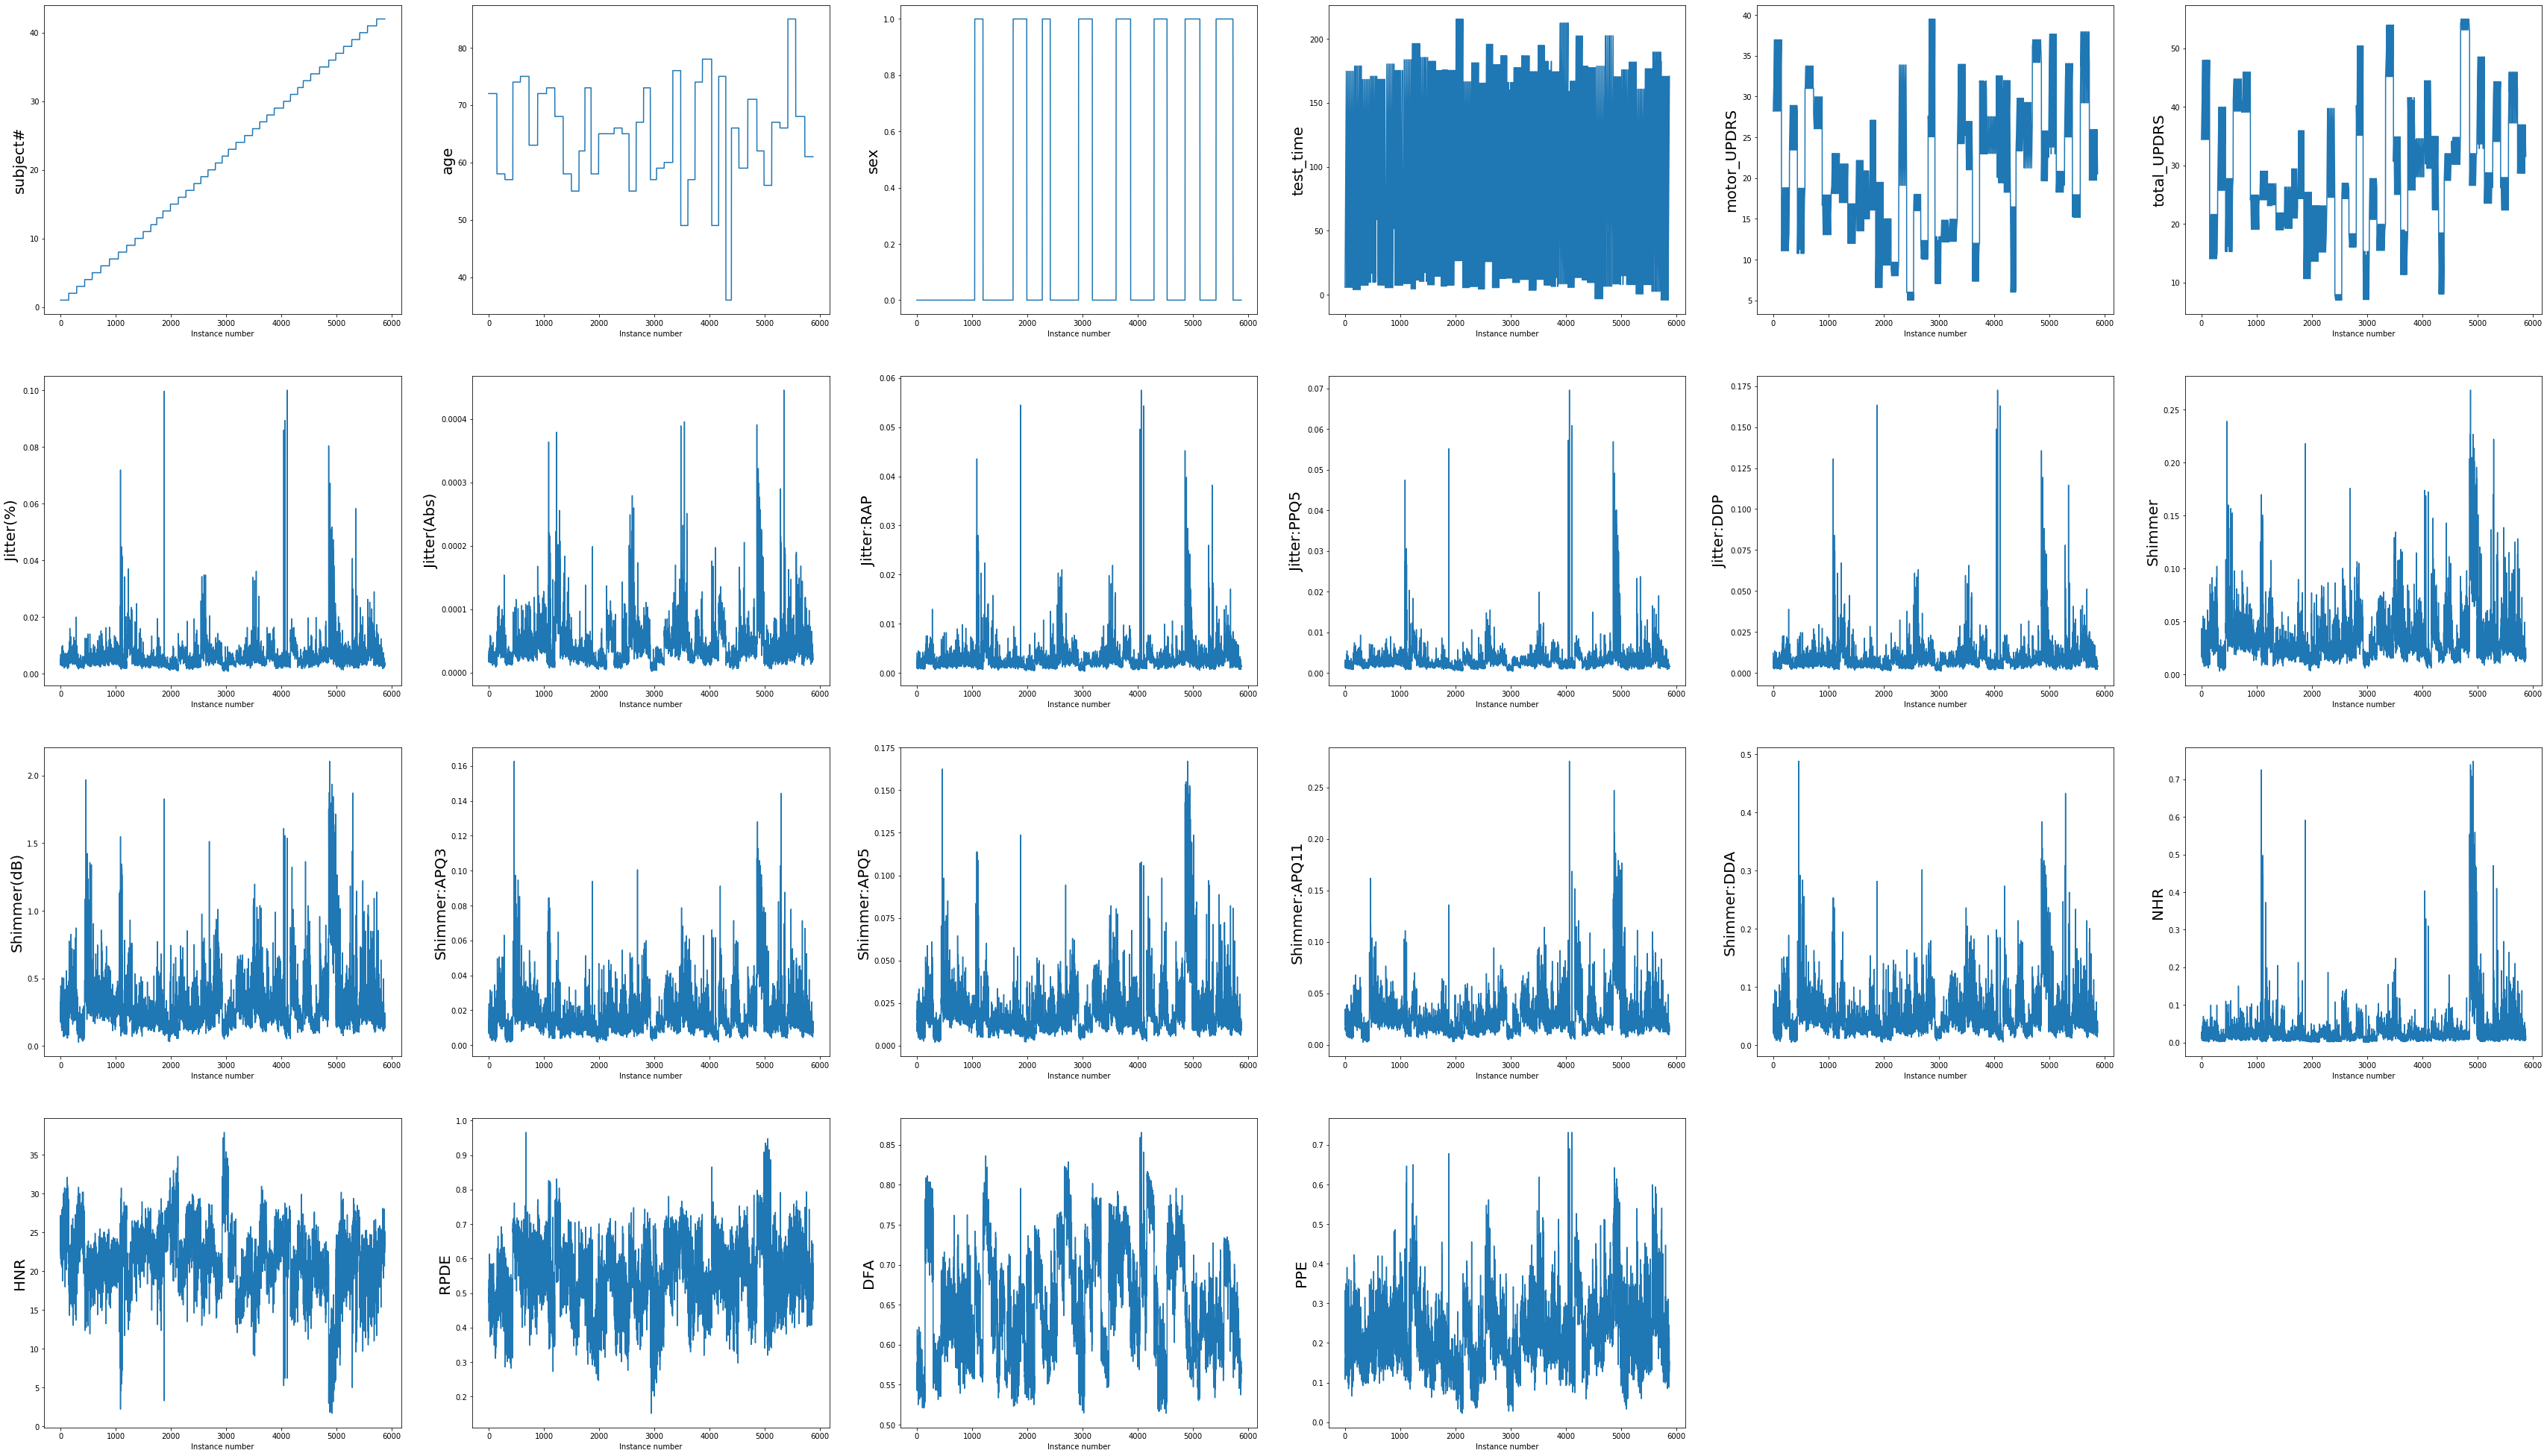

In [4]:
plt.figure(figsize=(60,90))
i =1
for col in df.columns:
    ax = plt.subplot(10,6, i)
    plt.plot(df[col])
    plt.ylabel(col, size=20)
    plt.xlabel('Instance number')
    i = i+1

This is not very useful... Let's therefore focus on our target variables and look at their distributions. 

Text(0, 0.5, 'counts')

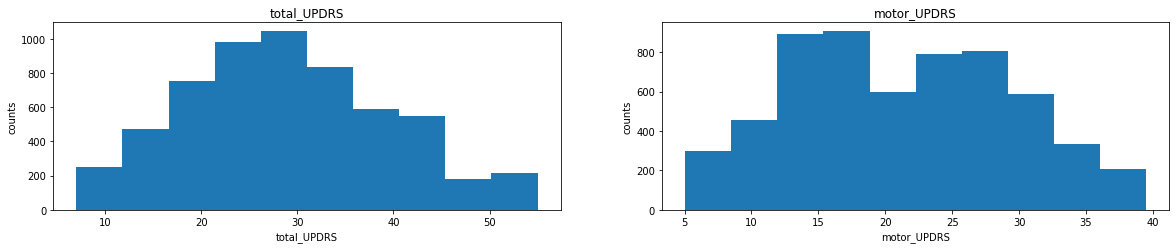

In [5]:
plt.figure(figsize=(20,20))
ax = plt.subplot(5,2, 1)
plt.hist(df['total_UPDRS'])
plt.title('total_UPDRS')
plt.xlabel('total_UPDRS')
plt.ylabel('counts')
ax = plt.subplot(5,2,2)
plt.hist(df['motor_UPDRS'])
plt.title('motor_UPDRS')
plt.xlabel('motor_UPDRS')
plt.ylabel('counts')

They both follow a normal distribution. Now what we can do to have a better idea how the independent variables relate to the dependent variables is to plot one against the other. Let's first plot each independent variables against the total UPDRS mean for that variable.

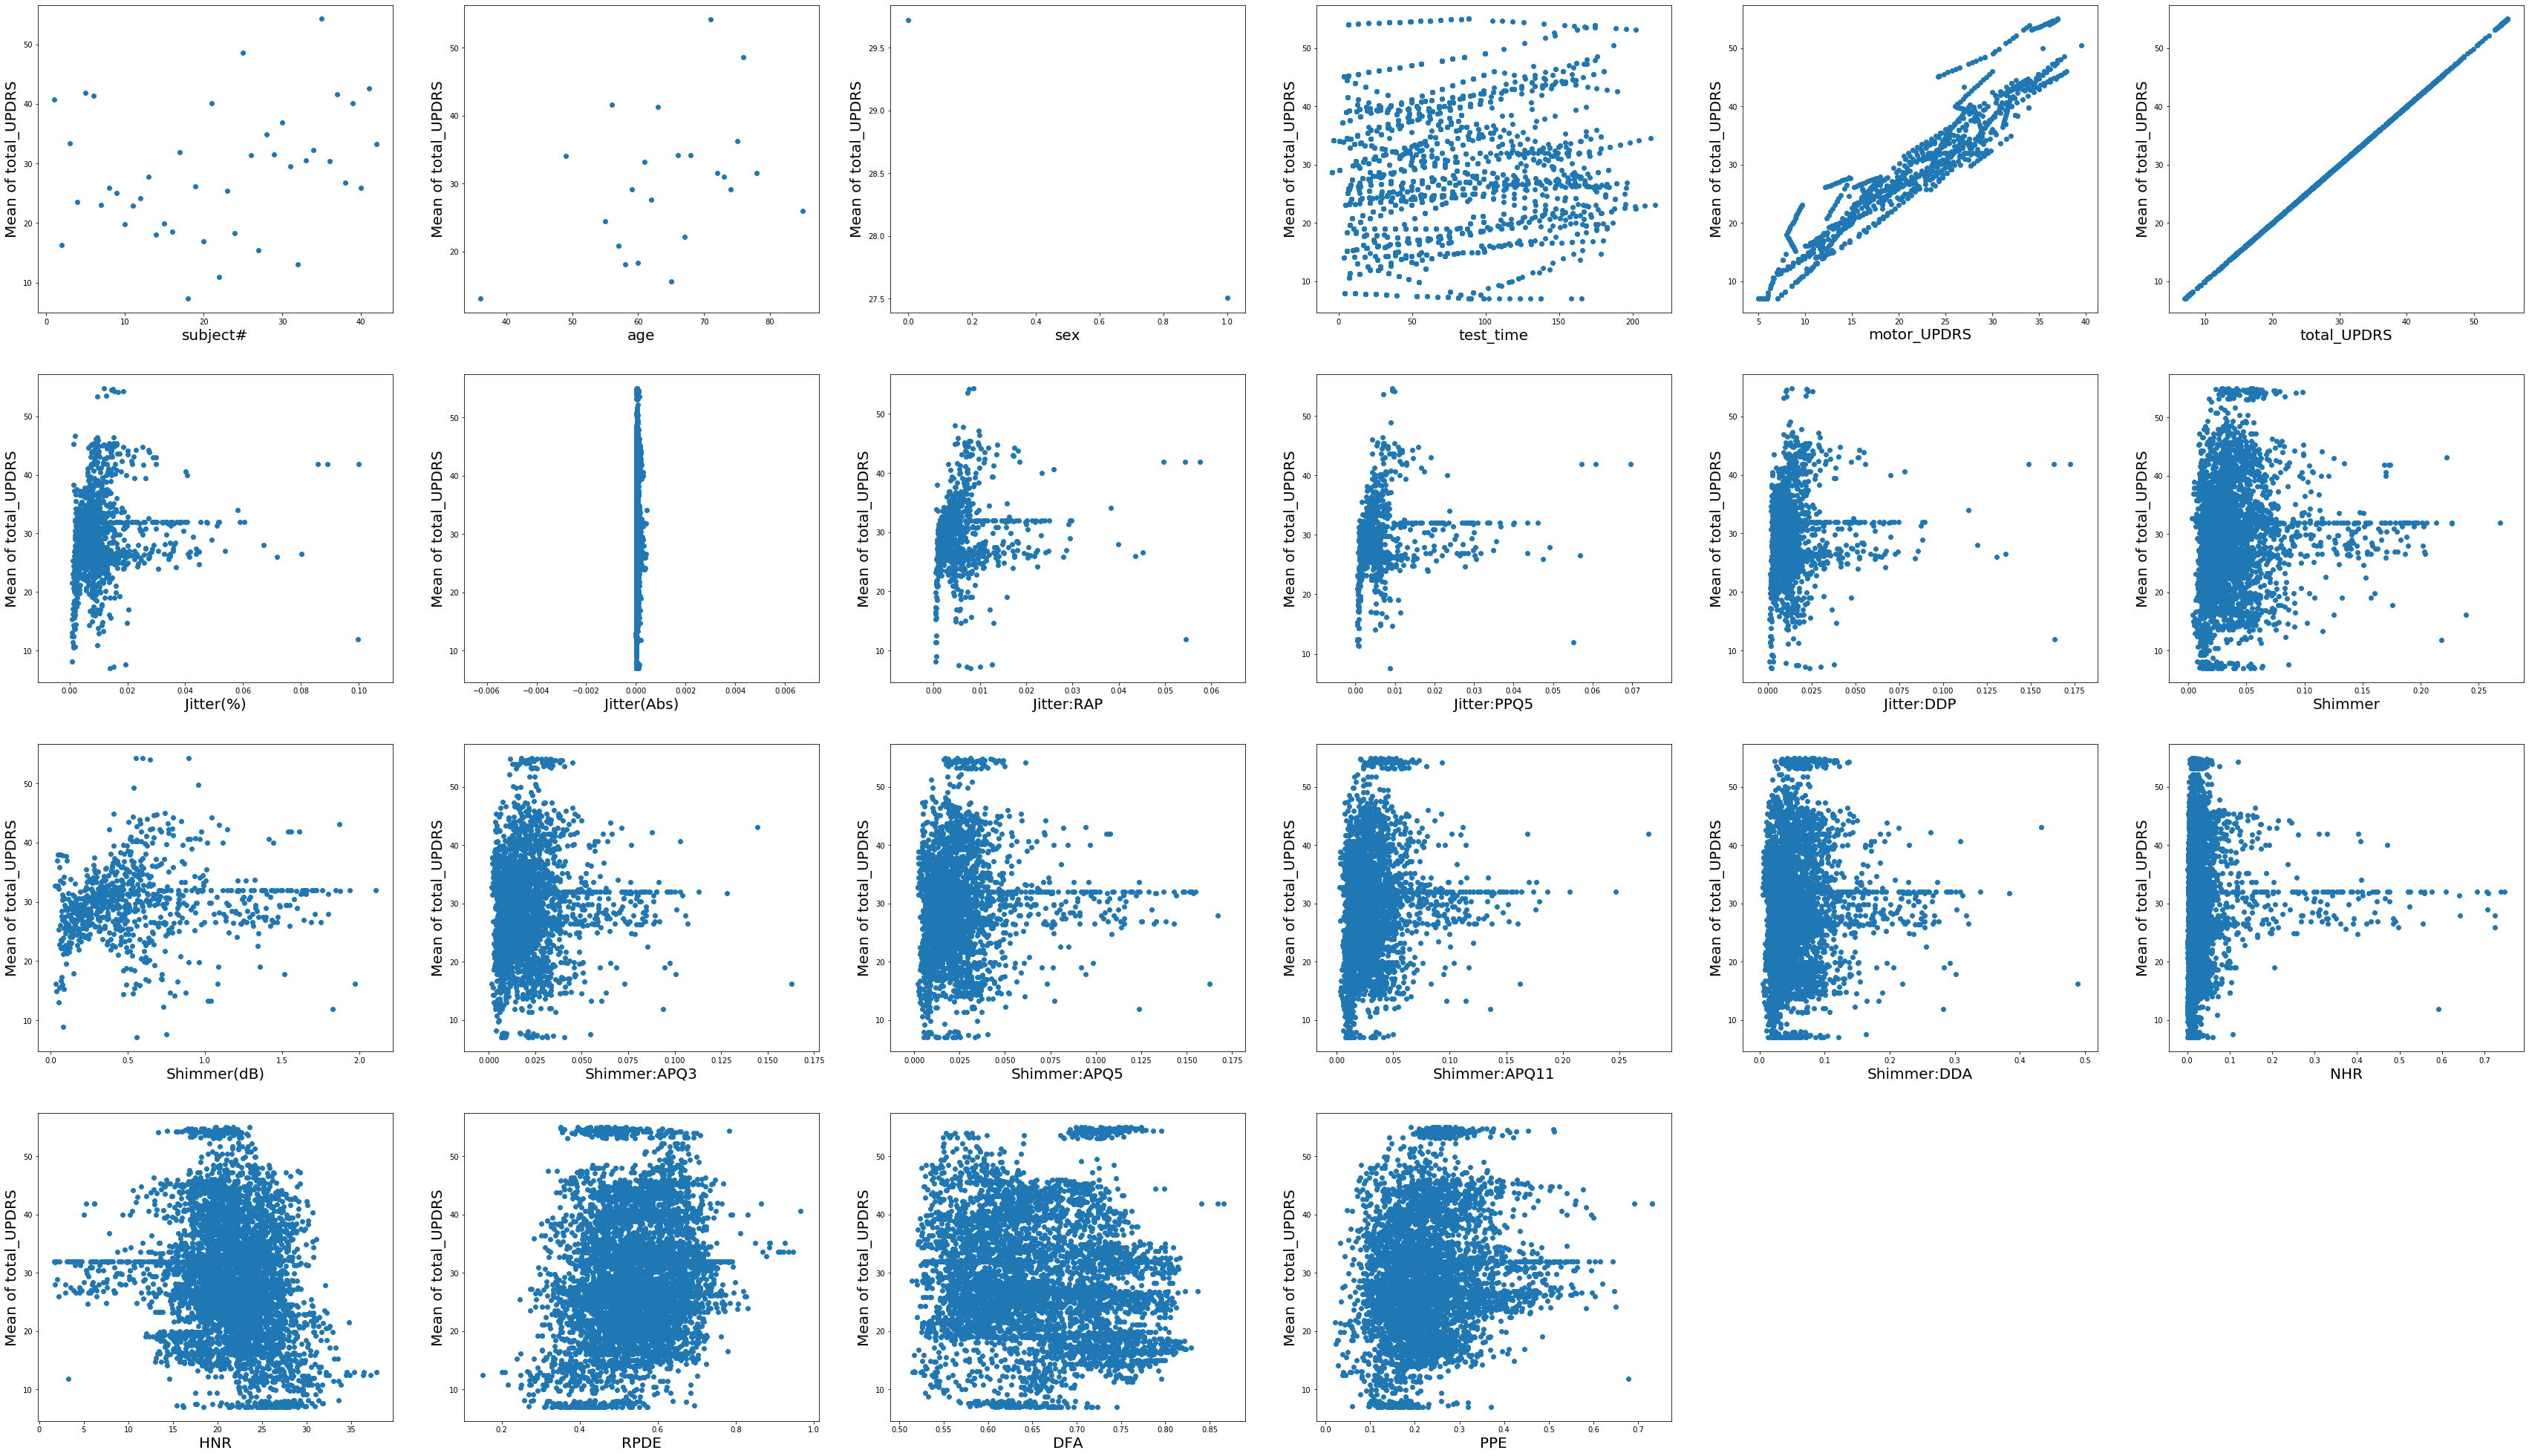

In [6]:
plt.figure(figsize=(60,90))
i =1
for col in df.columns:
    UPDRS_var = df.groupby(col).total_UPDRS.mean()
    var = df.groupby(col).size()
    ax = plt.subplot(10,6, i)
    plt.scatter(var.index,UPDRS_var)
    plt.xlabel(col, size=20)
    plt.ylabel('Mean of total_UPDRS', size=20)
    i = i+1

This is interesting. None of the independent variables are linearly related to total UPDRS, this infer that a linear regression model would perform terribly at modelling these data. Let's now look at the relationship between the independent variables and the second value to predict, the motor UPDRS.

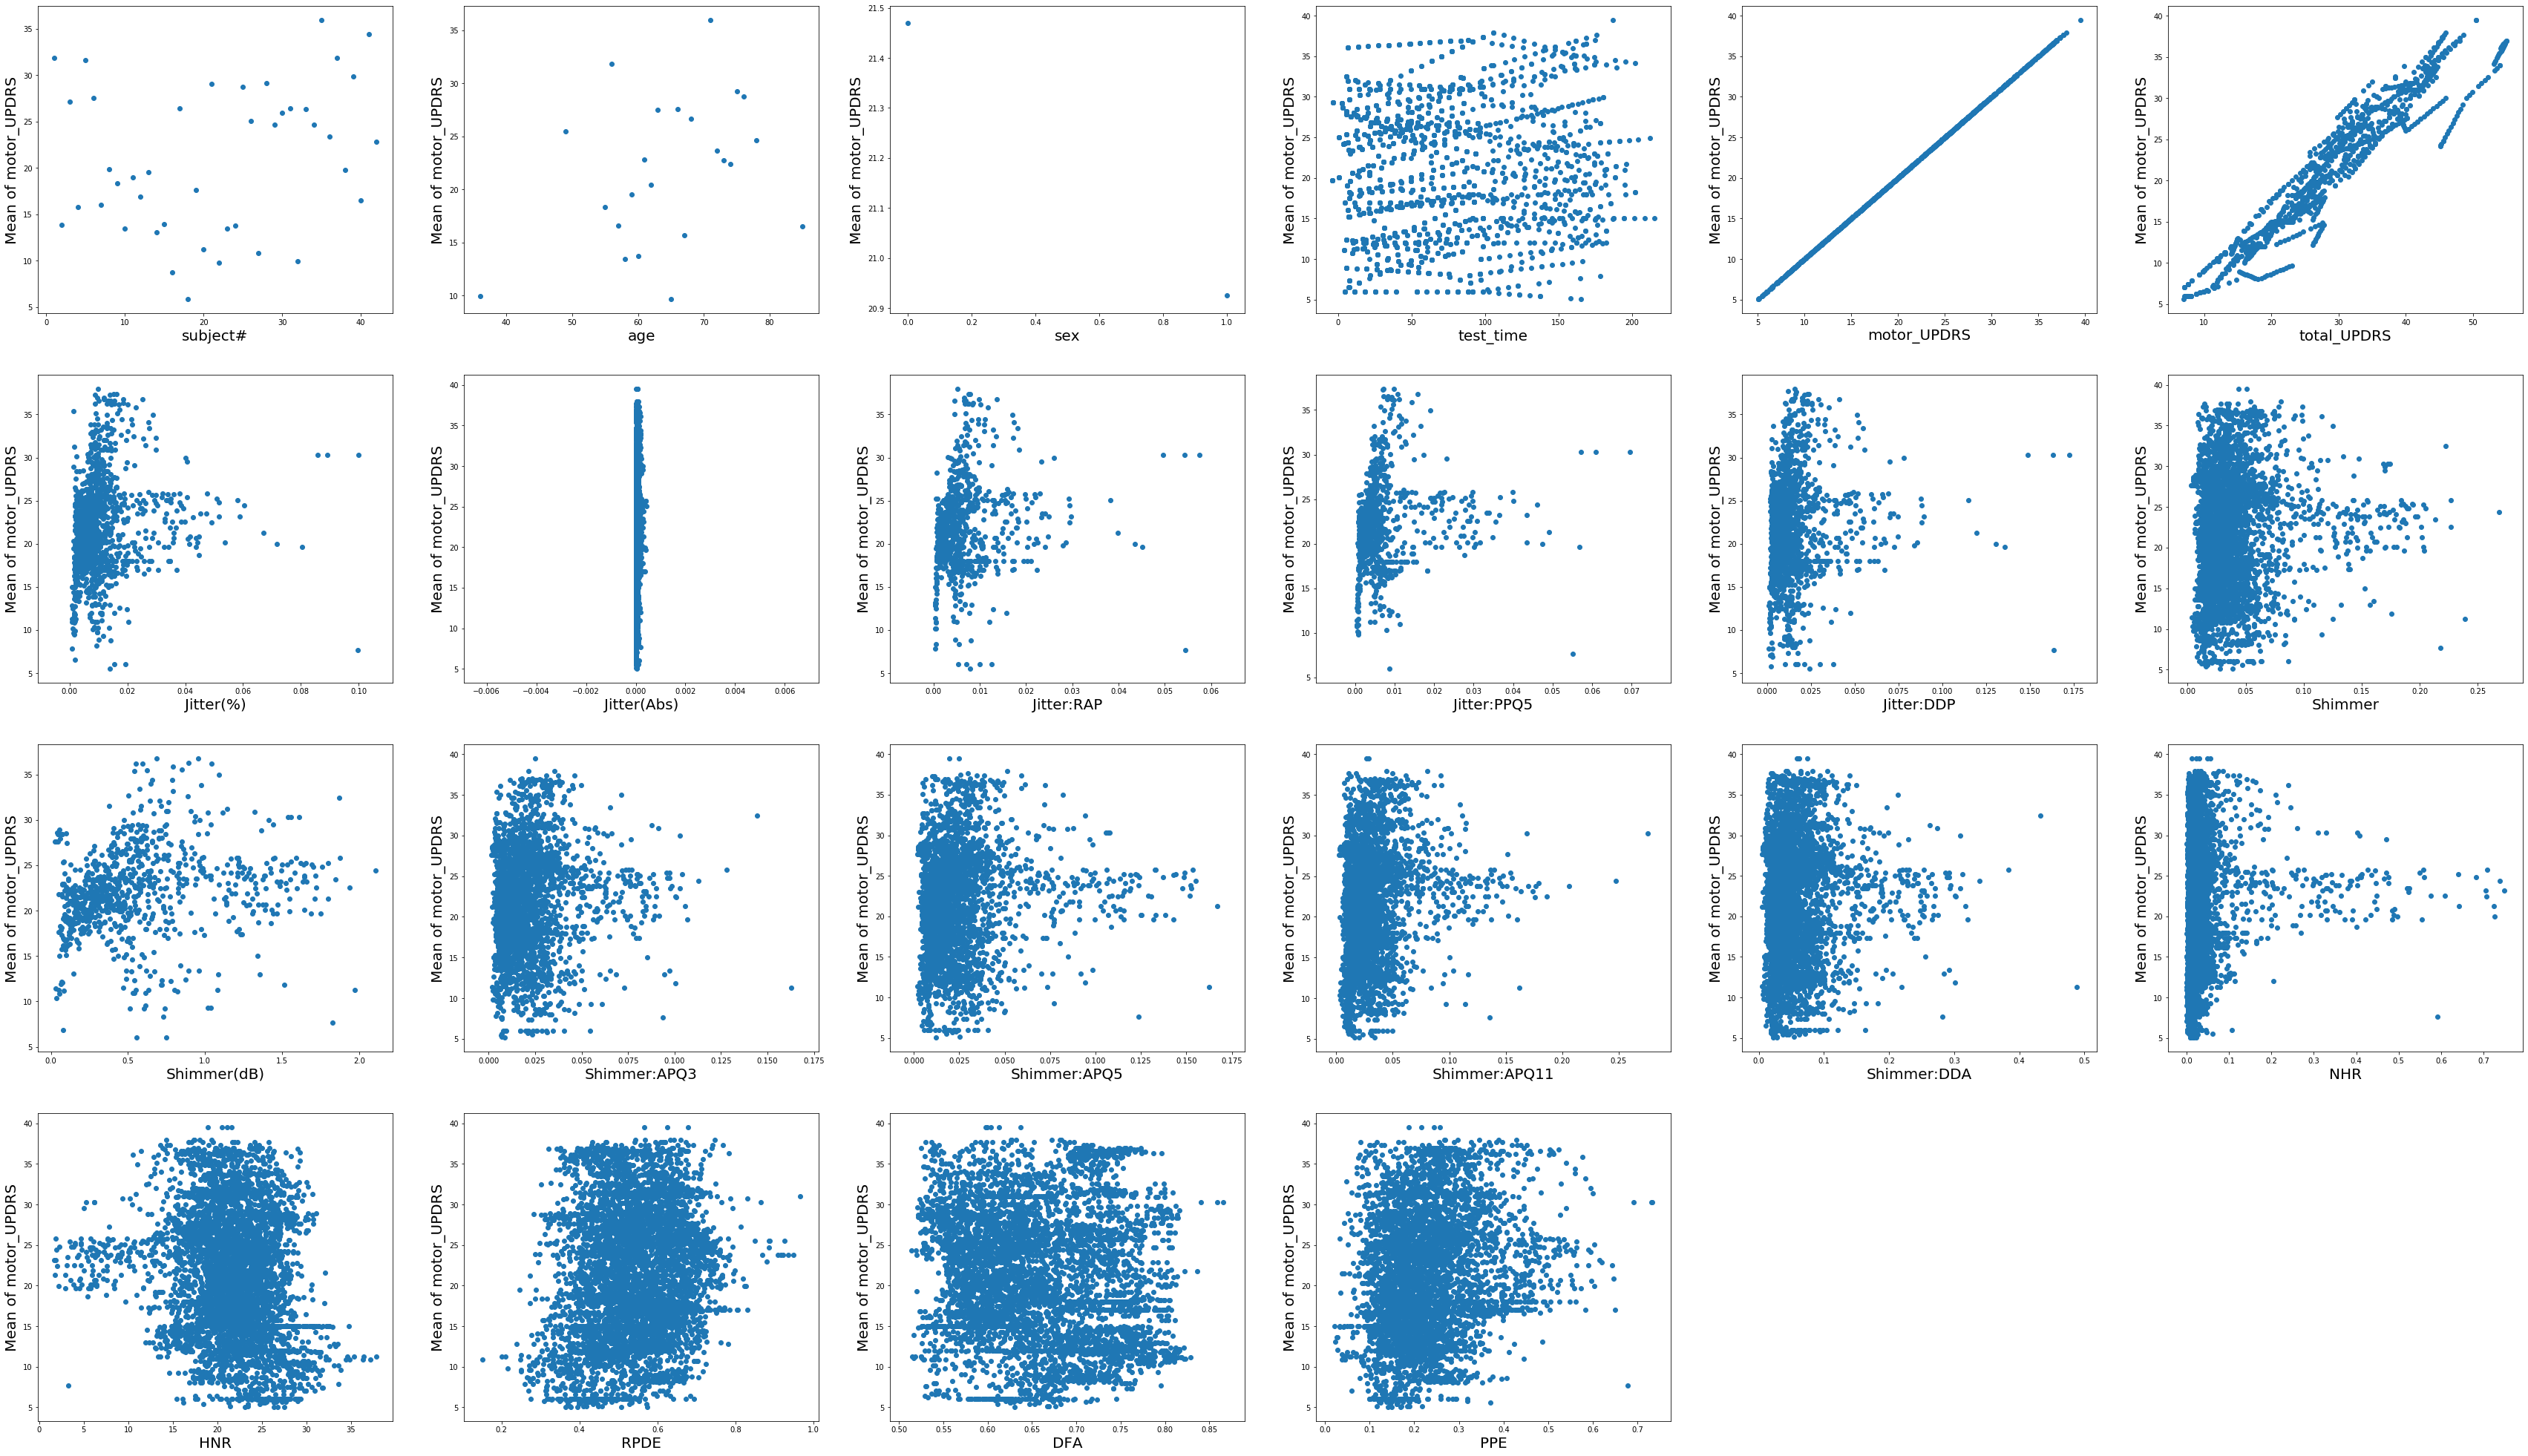

In [7]:
plt.figure(figsize=(60,90))
i =1
for col in df.columns:
    mot_UPDRS_var = df.groupby(col).motor_UPDRS.mean()
    var = df.groupby(col).size()
    ax = plt.subplot(10,6, i)
    plt.scatter(var.index,mot_UPDRS_var)
    plt.xlabel(col, size=20)
    plt.ylabel('Mean of motor_UPDRS', size=20)
    i = i+1

It makes sense that the variables follow the relatively same behaviour than for the total UPDRS as the two target variables are linearly correlated (as can be seen in the plots). Now that we have a better idea of our data, let's prepare them for the modelling by checking for missing values

In [8]:
df.isnull().any()

subject#         False
age              False
sex              False
test_time        False
motor_UPDRS      False
total_UPDRS      False
Jitter(%)        False
Jitter(Abs)      False
Jitter:RAP       False
Jitter:PPQ5      False
Jitter:DDP       False
Shimmer          False
Shimmer(dB)      False
Shimmer:APQ3     False
Shimmer:APQ5     False
Shimmer:APQ11    False
Shimmer:DDA      False
NHR              False
HNR              False
RPDE             False
DFA              False
PPE              False
dtype: bool

Perfect, we don't have missing values in this dataset. Let's drop the **subject#** column as this is just and identifier and won't be used for the prediction.

In [9]:
df.drop(['subject#'], axis=1, inplace = True)

## Modeling and evaluation

Let's divide our data into the independent variables and the target variables. Here, we have to be careful that we have a multi-output problem, hence our target *y* will be composed of two columns.

In [10]:
X = df.loc[:, (df.columns != 'motor_UPDRS') & (df.columns != 'total_UPDRS')].values
y = df.loc[:, (df.columns == 'motor_UPDRS') | (df.columns == 'total_UPDRS')].values

In [11]:
#We divide into a training and test set with 30% dedicated to testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
#We normalize the data 
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

We are ready to model our data. We noticed that a linear regression would perform terribly at modelling our data because no linear relationships appear independently between the independent and target variables, let's see if we were right. Here we don't need to use the *sklearn MultiOutput Regressor* library because LinearRegression natively supports multioutput predictions.

In [13]:
#We create the linear model and fit it to our training data
from sklearn.linear_model import LinearRegression
lr_regr = LinearRegression()
lr_regr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
#We predict the test data with our linear model and we compute the R2 score to see the proportion of variance of the dependent variables that can be explained by the independent variables
from sklearn.metrics import r2_score
y_lr = lr_regr.predict(X_test)
r2_score(y_test, y_lr)

0.15286794900810952

That was expected. From the plots above, we infer that, although better than a linear model, a Support Vector Regressor would perform terribly bad as well, as no hyperplanes seem to divide our data (at least in 2D but confirmed by further analysis). One method that could perform well would be the Random Forest multi-output regression that would first cluster our data to build the trees and then take the mean prediction of our trees for the final output. The *sklearn RandomForestRegressor* also supports multioutput predictions. 

In [15]:
#We create the random forest regression model and fit it to our training data
#The choosing of the parameters have been determined by GridSearchCV
from sklearn.ensemble import RandomForestRegressor
rf_regr = RandomForestRegressor(n_estimators=100, max_depth=30,
                                random_state=2)
rf_regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=2, verbose=0,
                      warm_start=False)

In [16]:
y_rf = rf_regr.predict(X_test)
print('Random Forest R2 score for motor_UPDRS:', r2_score(y_test[:,0], y_rf[:,0]))
print('Random Forest R2 score for total_UPDRS:', r2_score(y_test[:,1], y_rf[:,1]))

Random Forest R2 score for motor_UPDRS: 0.9723816684617854
Random Forest R2 score for total_UPDRS: 0.9694811435851974


This is a really good fit, let's look at the mean squared error of the model. 

In [17]:
print('Random Forest MSE for motor_UPDRS:', mean_squared_error(y_test[:,0], y_rf[:,0]))
print('Random Forest MSE for total_UPDRS:', mean_squared_error(y_test[:,1], y_rf[:,1]))

Random Forest MSE for motor_UPDRS: 1.7947529523069783
Random Forest MSE for total_UPDRS: 3.3651793636949763


The mean squared error is larger for total_UPDRS, this might be due to the higher values to be predicted for the total UPDRS. Now we look at another method that would be appropriate for modelling our data: a neural network with two outputs for the two target variables.

In [18]:
#We load the necessary libraries to build our MLP
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [19]:
#We build a MLP with one hidden layer of 20 neurons 
nn_reg = Sequential()
nn_reg.add(Dense(19, input_shape=(X.shape[1],)))
nn_reg.add(Dense(20, activation='tanh'))
nn_reg.add(Dense(y.shape[1], activation='relu'))
nn_reg.compile(optimizer='adam', loss='mean_squared_error')
nn_reg.fit(X_train, y_train, batch_size=1, epochs=50, validation_split=0.25, shuffle=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3084 samples, validate on 1028 samples
Epoch 1/50
3084/3084 [==============================] - 5s 2ms/step - loss: 237.4571 - val_loss: 82.5548
Epoch 2/50
3084/3084 [==============================] - 5s 2ms/step - loss: 75.9648 - val_loss: 77.0132
Epoch 3/50
3084/3084 [==============================] - 5s 2ms/step - loss: 71.4963 - val_loss: 70.1833
Epoch 4/50
3084/3084 [==============================] - 5s 2ms/step - loss: 65.8321 - val_loss: 64.5822
Epoch 5/50
3084/3084 [==============================] - 5s 2ms/step - loss: 60.7604 - val_loss: 60.8567
Epoch 6/50
3084/3084 [==============================] - 5s 2ms/step - loss: 57.0718 - val_loss: 60.4593
Epoch 7/50
3084/3084 [==============================] - 5s 2ms/step - loss: 53.8852 - val_loss: 56.2181
Epoch 8/50
3084/3084 [==============================] - 5s 2ms/step - loss: 51.6062 - val_loss: 54.9933

In [20]:
y_nn = nn_reg.predict(X_test)
print('Neural Network R2 score for motor_UPDRS', r2_score(y_test[:,0],y_nn[:,0]))
print('Neural Network R2 score for total_UPDRS', r2_score(y_test[:,1],y_nn[:,1]))

Neural Network R2 score for motor_UPDRS 0.5819638380893458
Neural Network R2 score for total_UPDRS 0.5853850355358245


We see that the mean squared errors (loss values) are much larger and the R2 value is much lower than for the Random Forest regressor. This is because further steps need to be done, assessing the number of layers and neurons to use, look at the plot of the loss vs the number of epochs to check where to stop, checking which activation functions are more appropriate, or take a larger training set. Due to shortage of time, we will leave this as exercise given that we already have a good model to use for the prediction of the stage of a patient's Parkinson's Disease.

## Conclusion

The goal of this project was to predict the total UPDRS and motor UPDRS of a patient. From the analysis, we found out that the **Random Forest Regressor** model performed the best, with an average R2 value of 0.97 and an average mean squared error of 2.58. We attempted to build a Neural Network to respond to the problem but further tuning is required and given the high performances of the Random Forest Regressor model, it is doubtful that a Neural Network would perform better. Now let's look at the predictions of our best model.

Text(0, 0.5, 'Predicted total_UPDRS value')

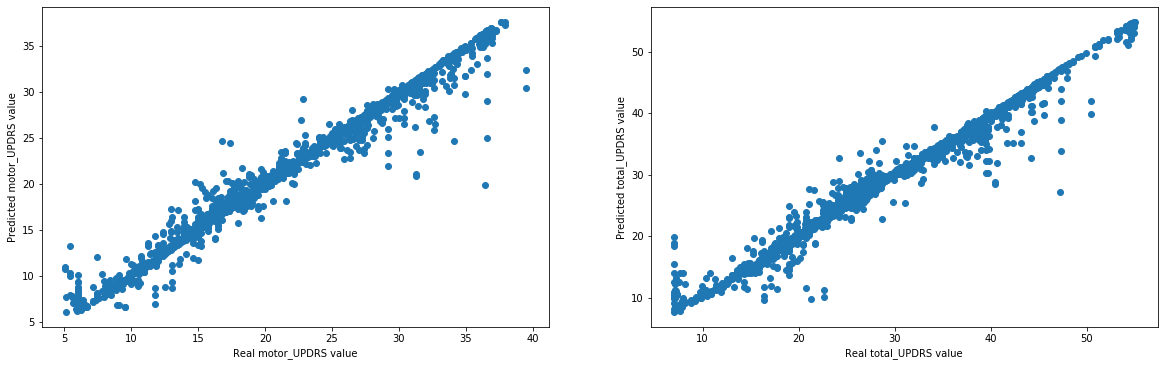

In [21]:
plt.figure(figsize=(20,20))
ax = plt.subplot(3,2, 1)
plt.scatter(y_test[:,0], y_rf[:,0])
plt.xlabel('Real motor_UPDRS value')
plt.ylabel('Predicted motor_UPDRS value')
ax = plt.subplot(3,2, 2)
plt.scatter(y_test[:,1], y_rf[:,1])
plt.xlabel('Real total_UPDRS value')
plt.ylabel('Predicted total_UPDRS value')

A perfect fit would be a straight line but we see that the model approaches it successfully. 